In [59]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_HOME'] = '/usr/local/cuda-7.5'

import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, merge
from keras.engine import Input, Model
from keras.optimizers import SGD
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
import json
import time

import matplotlib.pyplot as plt
from keras.utils import plot_model

In [60]:
def inception_resnet_v2_stem(x):
    # in original inception-resnet-v2, conv stride is 2
    #Conv2D(64, kernel_size=(1, 1), strides=(1, 1), padding="same", activation='relu', 
    #       input_shape=x)
    
    x = Convolution2D(32//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(x)
    x = Convolution2D(32//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(x)
    x = Convolution2D(64//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    
    # in original inception-resnet-v2, stride is 2
    a = MaxPooling2D((3, 3), strides=(1, 1), border_mode='valid', dim_ordering='tf')(x)
    # in original inception-resnet-v2, conv stride is 2
    b = Convolution2D(96//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(x)
    x = merge([a, b], mode='concat', concat_axis=-1)
    
    a = Convolution2D(64//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    a = Convolution2D(96//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(a)
    b = Convolution2D(64//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    b = Convolution2D(64//nb_filters_reduction_factor, 7, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(b)
    b = Convolution2D(64//nb_filters_reduction_factor, 1, 7, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(b)
    b = Convolution2D(96//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(b)
    x = merge([a, b], mode='concat', concat_axis=-1)
    
    # in original inception-resnet-v2, conv stride should be 2
    a = Convolution2D(192//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(x)
    # in original inception-resnet-v2, stride is 2
    b = MaxPooling2D((3, 3), strides=(1, 1), border_mode='valid', dim_ordering='tf')(x)
    x = merge([a, b], mode='concat', concat_axis=-1)
    
    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_A(x):
    shortcut = x
    
    a = Convolution2D(32//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    
    b = Convolution2D(32//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    b = Convolution2D(32//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(b)
    
    c = Convolution2D(32//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    c = Convolution2D(48//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)
    c = Convolution2D(64//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)
    
    x = merge([a, b, c], mode='concat', concat_axis=-1)
    x = Convolution2D(384//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='linear',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    
    x = merge([shortcut, x], mode='sum')
    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_reduction_A(x):
    a = MaxPooling2D((3, 3), strides=(2, 2), border_mode='valid', dim_ordering='tf')(x)
    b = Convolution2D(384//nb_filters_reduction_factor, 3, 3, subsample=(2, 2), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(x)
    c = Convolution2D(256//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    c = Convolution2D(256//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)
    c = Convolution2D(384//nb_filters_reduction_factor, 3, 3, subsample=(2, 2), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(c)
    
    x = merge([a, b, c], mode='concat', concat_axis=-1)
    
    return x
    

def inception_resnet_v2_B(x):
    shortcut = x
    
    a = Convolution2D(192//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    
    b = Convolution2D(128//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    b = Convolution2D(160//nb_filters_reduction_factor, 1, 7, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(b)
    b = Convolution2D(192//nb_filters_reduction_factor, 7, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(b)
    
    x = merge([a, b], mode='concat', concat_axis=-1)
    x = Convolution2D(1154//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='linear',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    
    x = merge([shortcut, x], mode='sum')
    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_reduction_B(x):
    a = MaxPooling2D((3, 3), strides=(2, 2), border_mode='valid', dim_ordering='tf')(x)
    b = Convolution2D(256//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    b = Convolution2D(288//nb_filters_reduction_factor, 3, 3, subsample=(2, 2), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(b)
    c = Convolution2D(256//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    c = Convolution2D(288//nb_filters_reduction_factor, 3, 3, subsample=(2, 2), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(c)
    d = Convolution2D(256//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    d = Convolution2D(288//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(d)
    d = Convolution2D(320//nb_filters_reduction_factor, 3, 3, subsample=(2, 2), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(d)
    
    x = merge([a, b, c, d], mode='concat', concat_axis=-1)
    
    return x


def inception_resnet_v2_C(x):
    shortcut = x
    
    a = Convolution2D(192//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    
    b = Convolution2D(192//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    b = Convolution2D(224//nb_filters_reduction_factor, 1, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(b)
    b = Convolution2D(256//nb_filters_reduction_factor, 3, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(b)
    
    x = merge([a, b], mode='concat', concat_axis=-1)
    x = Convolution2D(2048//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='linear',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    
    x = merge([shortcut, x], mode='sum')
    x = Activation('relu')(x)
    
    return x

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), padding="valid", data_format="channels_last", activation="relu", strides=(1, 1), kernel_initializer="he_normal")`
  import sys
C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), padding="valid", data_format="channels_last", activation="relu", strides=(1, 1), kernel_initializer="he_normal")`
  if __name__ == '__main__':
C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), padding="same", data_format="channels_last", activation="relu", strides=(1, 1), kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\KHM\AppData\Local\conda\conda\envs\py35

C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:122: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (3, 3), padding="valid", data_format="channels_last", activation="relu", strides=(2, 2), kernel_initializer="he_normal")`
C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:124: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), padding="same", data_format="channels_last", activation="relu", strides=(1, 1), kernel_initializer="he_normal")`
C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:126: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (3, 3), padding="same", data_format="channels_last", activation="relu", strides=(1, 1), kernel_initializer="he_normal")`
C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Update your `Conv2D` call to the K

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_36 (InputLayer)            (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1058 (Conv2D)             (None, 30, 30, 4)     112         input_36[0][0]                   
____________________________________________________________________________________________________
conv2d_1059 (Conv2D)             (None, 28, 28, 4)     148         conv2d_1058[0][0]                
____________________________________________________________________________________________________
conv2d_1060 (Conv2D)             (None, 28, 28, 8)     296         conv2d_1059[0][0]                
___________________________________________________________________________________________

C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:95: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:95: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., callbacks=[], verbose=1, epochs=10, validation_data=(array([[[..., steps_per_epoch=390)`


Epoch 1/10
390/390 [==============================] - 263s - loss: 1.9251 - acc: 0.2522 - val_loss: 1.6638 - val_acc: 0.3701
Epoch 2/10
390/390 [==============================] - 258s - loss: 1.6058 - acc: 0.4022 - val_loss: 1.4215 - val_acc: 0.4791
Epoch 3/10
390/390 [==============================] - 254s - loss: 1.4341 - acc: 0.4778 - val_loss: 1.3340 - val_acc: 0.5189
Epoch 4/10
390/390 [==============================] - 254s - loss: 1.3605 - acc: 0.5103 - val_loss: 1.2805 - val_acc: 0.5334
Epoch 5/10
390/390 [==============================] - 256s - loss: 1.2843 - acc: 0.5375 - val_loss: 1.1973 - val_acc: 0.5738
Epoch 6/10
390/390 [==============================] - 255s - loss: 1.2257 - acc: 0.5628 - val_loss: 1.1604 - val_acc: 0.5788
Epoch 7/10
390/390 [==============================] - 255s - loss: 1.1887 - acc: 0.5782 - val_loss: 1.0661 - val_acc: 0.6188
Epoch 8/10
390/390 [==============================] - 256s - loss: 1.1370 - acc: 0.5952 - val_loss: 1.0203 - val_acc: 0.6355


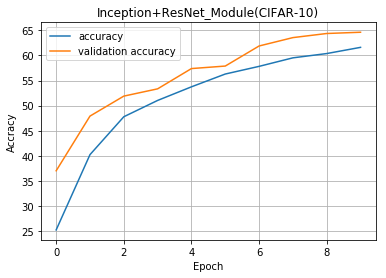

validation accuracy :  0.6462


In [70]:
nb_classes = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# reorder dimensions for tensorflow
x_train = np.transpose(x_train.astype('float32') / 255., (0, 1, 2, 3))
x_test = np.transpose(x_test.astype('float32') / 255., (0, 1, 2, 3))
#x_train = np.transpose(x_train.astype('float32') / 255., (0, 2, 3, 1))
#x_test = np.transpose(x_test.astype('float32') / 255., (0, 2, 3, 1))
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# we reduce # filters by factor of 8 compared to original inception-v4
nb_filters_reduction_factor = 8

#%%time

img_rows, img_cols = 32, 32
img_channels = 3

# in original inception-resnet-v2, these are 5, 10, 5, respectively
num_A_blocks = 1
num_B_blocks = 1
num_C_blocks = 1

inputs = Input(shape=(img_rows, img_cols, img_channels))

x = inception_resnet_v2_stem(inputs)

for i in range(num_A_blocks):
    x = inception_resnet_v2_A(x)
x = inception_resnet_v2_reduction_A(x)
for i in range(num_B_blocks):
    x = inception_resnet_v2_B(x)
x = inception_resnet_v2_reduction_B(x)
for i in range(num_C_blocks):
    x = inception_resnet_v2_C(x)

x = AveragePooling2D(pool_size=(4, 4), strides=(1, 1), border_mode='valid', dim_ordering='tf')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(nb_classes, activation='softmax')(x)

model = Model(input=inputs, output=predictions)

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 128
nb_epoch = 10
data_augmentation = True

# Model saving callback
#checkpointer = ModelCheckpoint(filepath='stochastic_depth_cifar10.hdf5', verbose=1, save_best_only=True)

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                        validation_data=(x_test, y_test), shuffle=True,
                        callbacks=[])
else:
    print('Using real-time data augmentation.')

    # realtime data augmentation
    datagen_train = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        width_shift_range=0.125,
        height_shift_range=0.125,
        horizontal_flip=True,
        vertical_flip=False)
    datagen_train.fit(x_train)

    # fit the model on the batches generated by datagen.flow()
    his = model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                                  samples_per_epoch=x_train.shape[0], 
                                  #nb_epoch=2, verbose=1,
                                  nb_epoch=nb_epoch, verbose=1,
                                  validation_data=(x_test, y_test),
                                  callbacks=[])

# acc
acc = his.history["acc"]
val_acc = his.history["val_acc"]

acc_List = []
valacc_List = []

for i in acc:
    acc_List.append(i*100)

for i in val_acc:
    valacc_List.append(i*100)

plt.grid(True)
plt.plot(acc_List, label = 'accuracy')
plt.plot(valacc_List, label = 'validation accuracy')
plt.ylabel('Accracy')
plt.xlabel('Epoch')
plt.title(r'Inception+ResNet_Module(CIFAR-10)')
plt.legend()
plt.show()
plot_model(model, to_file='Inception_ResNet_model.png', show_shapes=True, show_layer_names=True) 

print("validation accuracy : ", val_acc[-1])